# ASTR 310 Lecture 19b - Fourier Transforms part 2 (timeseries analysis)

### Sunspots take 1

Download the file “SN_m_tot_V2.0.txt” from today’s exercise page on Canvas. This file contains the monthly average sunspot count for every month since January 1749 as compiled by the Solar Influences Data analysis Center in Belgium. We will work with the 3rd (“mean_date”) and 4th (“sunspot_number”) columns.

**a)** Read the file using Astropy or np.genfromtxt() and extract the two columns of data. Plot the sunspot number versus time to get a look at the data.  [2 pts]

In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy

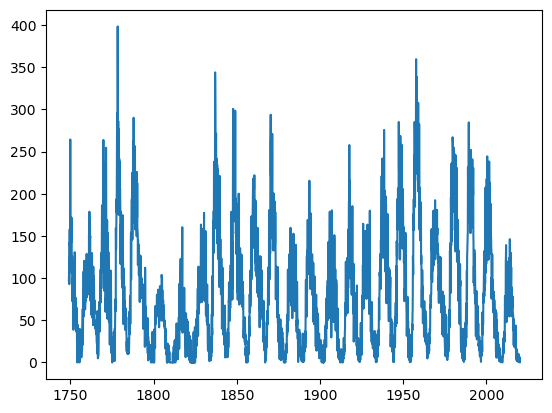

In [3]:
data = np.genfromtxt("SN_m_tot_V2.0.txt")
mean_date = data[:,2]
sunspot_number = data[:,3]
plt.plot(mean_date, sunspot_number)

**b)** Compute the FFT of the sunspot number data, then compute the periodogram estimate of the power spectrum and plot it versus frequency on a log-log scale. Keep in mind that the sunspot number is real-valued, so use the `rfft()` routine. Also, in constructing the array of frequencies, you can pass the sampling interval as a second argument to `rfftfreq()`.  See the Reading for more info.  The sampling interval is 1 month = 1/12 year. Add appropriate axis labels!  [3 pts]

Text(0.5, 1.0, 'Sunspot Power Spectrum')

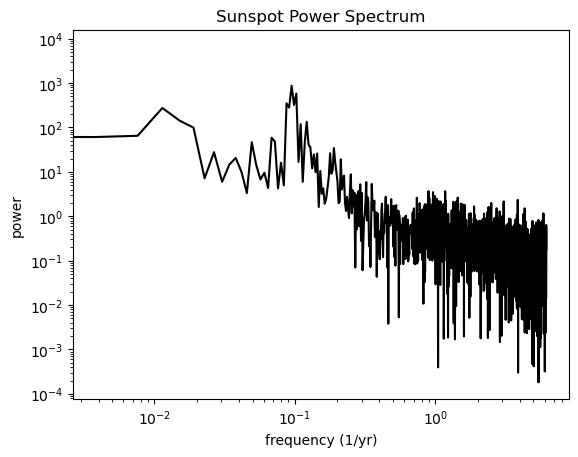

In [4]:
N = len(sunspot_number)
dx = mean_date[1] - mean_date[0]
fhat = np.fft.rfft(sunspot_number)
k = np.fft.rfftfreq(N, dx)

P = np.abs(fhat)**2 / N**2
P[1:-1] = 2*P[1:-1]

plt.loglog(k, P, 'k-')
plt.xlabel("frequency (1/yr)")
plt.ylabel("power")
plt.title("Sunspot Power Spectrum")

### Sunspots take 2

That power spectrum looks pretty ratty. The input data are very noisy on short timescales (month to month). The normal periodogram estimator spreads the influence of that noise across the whole power spectrum. We can improve the estimator if we break up the time series into $K$ non-overlapping segments and average the power spectra from the segments (Bartlett’s method).  There's a figure in today's slides that is supposed to help explain the process.

**a)** Modify your code to implement Bartlett’s method with $K=5$. 
That is, if the initial dataset has $N$ samples, you should take the Fourier transforms of $K$ segments of length $N_\mathrm{seg} = 2(N//(2K))$ and produce $K$ periodograms. Each periodogram will have $N_\mathrm{seg}//2+1$ frequency values rather than $N//2+1$.  Average the periodograms.  [5 pts]

In [5]:
K = 5
N_seg = 2*(N//(2*K))
dx = mean_date[1] - mean_date[0]
segs_y = sunspot_number[0:K*N_seg].reshape((K, N_seg))
segs_x = mean_date[0:K*N_seg].reshape((K, N_seg))

spectra = []

for i in range(K):
    fhat = np.fft.rfft(segs_y[i])
    k = np.fft.rfftfreq(N_seg, dx)

    P = np.abs(fhat)**2 / N_seg**2
    P[1:-1] = 2*P[1:-1]
    spectra.append(P)

mean_P = np.mean(spectra, axis=0)

**b)** Plot the resulting power spectrum. You should now be able to see a clear peak corresponding to a period of ~11 years and a hint of an overtone at twice the fundamental frequency.  [2 pts]

Text(0.5, 1.0, 'Sunspot Power Spectrum')

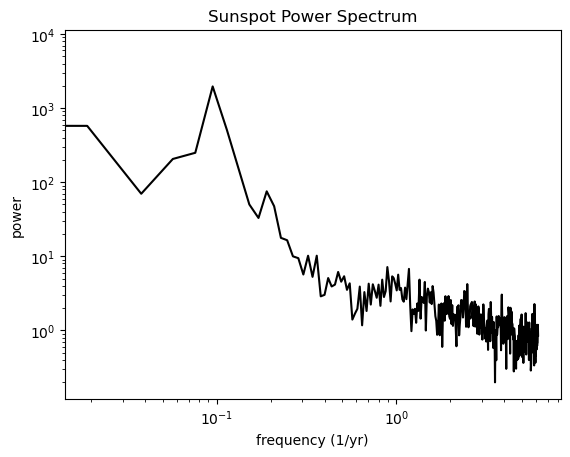

In [6]:
plt.loglog(k, mean_P, 'k-')
plt.xlabel("frequency (1/yr)")
plt.ylabel("power")
plt.title("Sunspot Power Spectrum")

### Sunspots take 3

The Bartlett periodogram is an improvement, but we can do even better using Welch’s method. For this method we allow the segments to overlap by 50% and also, before doing Fourier transforms, multiply the segments by a filter function.

**a)** Modify your code to implement Welch’s method with $K=5$. The segments should have length $N_\mathrm{seg} = 2N//(K+1)$ and be offset by $N_\mathrm{seg}//2$ elements from the start of the original array. Before computing the FFT, multiply each segment by the Welch filter function:
$$ W_n = 1 - \biggl(\frac{n-N_\mathrm{seg}/2}{N_\mathrm{seg}/2}\biggr)^2 ~~~~~ n=0 \ldots N_\mathrm{seg}-1$$



Since you multiplied the segments by a weighting function, you should normalize the power spectrum accordingly.  The power spectrum of each segment should be computed using 

$$ \frac{N_\mathrm{seg}}{\sum_{n=0}^{N_\mathrm{seg}-1} W_n^2} P_m$$

where $P_m$ is the normal periodogram estimate for the segment.  [4 pts]

In [7]:
def welch(N_seg):
    welch = []
    for n in range(0, N_seg):
        wn = 1 - ((n - N_seg/2)/(N_seg/2))**2
        welch.append(wn)
    return np.array(welch)

In [8]:
def normalize(P, W, N_seg):
    return N_seg / np.sum(W**2) * P

In [9]:
K = 5
N_seg = 2*N // (K + 1)
offset = N_seg // 2

segs_y = []
segs_x = []

for i in range(K):
    x = sunspot_number[offset*i:(offset*i)+N_seg]
    segs_y.append(x)
    y = mean_date[offset*i:(offset*i)+N_seg]
    segs_x.append(y*welch(N_seg))

spectra = []

for i in range(K):
    fhat = np.fft.rfft(segs_y[i])
    k = np.fft.rfftfreq(N_seg, dx)

    P = np.abs(fhat)**2 / N_seg**2
    P[1:-1] = 2*P[1:-1]
    spectra.append(P)

spectra = [normalize(s, welch(N_seg), N_seg) for s in spectra]
spectra
mean_P = np.mean(spectra, axis=0)

**b)** Compare your "by hand" implementation of Welch’s method with the canned version in `scipy.signal.welch`.  For a qualitative comparison, you can simply plot the two periodograms on the same figure (use different colors & label them).
Note - whereas `rfftfreq` takes the time interval between sampling points $dt$ as an argument, `scipy.signal.welch` takes the frequency sampling $dt^{-1}$ as an argument.  Also, the parabolic window function that we used above doesn’t exactly match any of the windowing functions named in scipy.signal, but it’s pretty close to a cosine window.  [4 pts]

In [10]:
k_scipy, P_scipy = scipy.signal.welch(sunspot_number, fs=1/dx, nperseg=N_seg, window='cosine', scaling='spectrum')

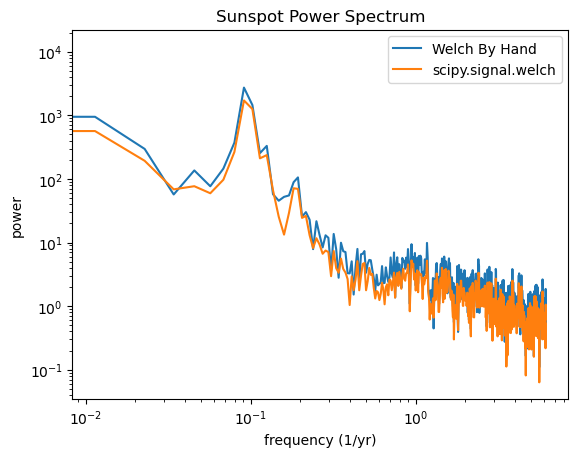

In [11]:
plt.loglog(k, mean_P, label="Welch By Hand")
plt.loglog(k_scipy, P_scipy, label="scipy.signal.welch")
plt.xlabel("frequency (1/yr)")
plt.ylabel("power")
plt.title("Sunspot Power Spectrum")
plt.legend()